In [2]:
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
from nltk.tokenize import sent_tokenize
import gensim.parsing.preprocessing as gen_preproc

import spacy
nlp = spacy.load('en_core_web_sm')

import keras
import keras.backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

# Data Loading and Cleanup
Identical to what occured in the Initial Models file

In [4]:
df = pd.read_csv( 'parsed_train.txt', sep='\t', header=None,
                   names=['label', 'text'] )
df['label'] = df['label'].apply(lambda x: int( x.replace("__label__", "") ) )

basicPreproc = [lambda x: x.lower(), gen_preproc.strip_tags, \
    gen_preproc.strip_punctuation, gen_preproc.strip_non_alphanum, \
    gen_preproc.strip_multiple_whitespaces] #, gen_preproc.strip_short, gen_preproc.remove_stopwords

df['basicProc'] = df['text'].apply(lambda x: ' '.join( gen_preproc.preprocess_string(x, basicPreproc)))
df['stemmed'] = df['basicProc'].apply(lambda x: gen_preproc.stem_text(x))
df['lemmatized'] = df['basicProc'].apply(lambda x: ' '.join( [token.lemma_ for token in nlp(x)] ) )
df.head()

,label,text,basicProc,stemmed,lemmatized
0,4,The Rock is destined to be the 21st Century 's...,the rock is destined to be the 21st century s ...,the rock is destin to be the 21st centuri s ne...,the rock be destine to be the 21st century s n...
1,5,The gorgeously elaborate continuation of `` Th...,the gorgeously elaborate continuation of the l...,the gorgeous elabor continu of the lord of the...,the gorgeously elaborate continuation of the l...
2,4,Singer/composer Bryan Adams contributes a slew...,singer composer bryan adams contributes a slew...,singer compos bryan adam contribut a slew of s...,singer composer bryan adams contribute a slew ...
3,3,You 'd think by now America would have had eno...,you d think by now america would have had enou...,you d think by now america would have had enou...,-PRON- d think by now america would have have ...
4,4,Yet the act is still charming here .,yet the act is still charming here,yet the act is still charm here,yet the act be still charm here


Do the same but for the test set.

In [5]:
test_df = pd.read_csv( 'parsed_test.txt', sep='\t', header=None,
                   names=['label', 'text'] )
test_df['label'] = test_df['label'].apply(lambda x: int( x.replace("__label__", "") ) )
test_df['basicProc'] = test_df['text'].apply(lambda x: ' '.join( gen_preproc.preprocess_string(x, basicPreproc)))
test_df['stemmed'] = test_df['basicProc'].apply(lambda x: gen_preproc.stem_text(x))
test_df['lemmatized'] = test_df['basicProc'].apply(lambda x: ' '.join( [token.lemma_ for token in nlp(x)] ) )
test_df.head()

,label,text,basicProc,stemmed,lemmatized
0,3,Effective but too-tepid biopic,effective but too tepid biopic,effect but too tepid biopic,effective but too tepid biopic
1,4,If you sometimes like to go to the movies to h...,if you sometimes like to go to the movies to h...,if you sometim like to go to the movi to have ...,if -PRON- sometimes like to go to the movie to...
2,5,"Emerges as something rare , an issue movie tha...",emerges as something rare an issue movie that ...,emerg as someth rare an issu movi that s so ho...,emerge as something rare an issue movie that s...
3,3,The film provides some great insight into the ...,the film provides some great insight into the ...,the film provid some great insight into the ne...,the film provide some great insight into the n...
4,5,Offers that rare combination of entertainment ...,offers that rare combination of entertainment ...,offer that rare combin of entertain and educ,offer that rare combination of entertainment a...


In [15]:
df['label'] = df['label'].apply(lambda x: float(x))
test_df['label'] = test_df['label'].apply(lambda x: float(x))
df.head()

,label,text,basicProc,stemmed,lemmatized
0,4.0,The Rock is destined to be the 21st Century 's...,the rock is destined to be the 21st century s ...,the rock is destin to be the 21st centuri s ne...,the rock be destine to be the 21st century s n...
1,5.0,The gorgeously elaborate continuation of `` Th...,the gorgeously elaborate continuation of the l...,the gorgeous elabor continu of the lord of the...,the gorgeously elaborate continuation of the l...
2,4.0,Singer/composer Bryan Adams contributes a slew...,singer composer bryan adams contributes a slew...,singer compos bryan adam contribut a slew of s...,singer composer bryan adams contribute a slew ...
3,3.0,You 'd think by now America would have had eno...,you d think by now america would have had enou...,you d think by now america would have had enou...,-PRON- d think by now america would have have ...
4,4.0,Yet the act is still charming here .,yet the act is still charming here,yet the act is still charm here,yet the act be still charm here


## Setup Tokenization for input into LSTM

Like other networks, an LSTM takes inputs of vectors. Therefore we do need to turn our input text back into vectors. However, we will be feeding in each word at a time, so its not necessary to do anything too complicated. 

#### Questions:
- How are ngrams used in an LSTM?
- Is there any benefit to feeding in something like a w2v vector instead of a one-hot encoded vector? One hot obviously relies on a consistant vocab, which fasttext could get around. 
- Why would you want to stack multiple levels of LSTMs on top of eachother?


In [21]:
maxNumWords = 5000 #Most frequent
maxSeqLeng = 45 #See Initial Models file for reviews length distro justifying this. 
embedDim = 100
epochs = 10
batch_size = 64

In [9]:
tokenizer = Tokenizer( num_words=maxNumWords ) #already did other preproc, but could include more here
tokenizer.fit_on_texts(df['lemmatized'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 12724 unique tokens.


In [16]:
X = tokenizer.texts_to_sequences( df['lemmatized'].values )
X = pad_sequences( X, maxlen=maxSeqLeng) #Adds 0's in front of my sentances that are shorter than maxSeqLen
Y = np.array( list( df['label'] ) )

print('Shape of Input data tensor:', X.shape)
print( "Vector 0: \n", X[0] )
print( "Vector 1: \n", X[1] )
print() 
print( "Line 0: \n", df['lemmatized'][0] )
print( "Line 1: \n", df['lemmatized'][1] )

Shape of Input data tensor: (8544, 45)
Vector 0: 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    1  490    6 3229    7    6    1 2701  893    8   93    4
    9    2    8   69    7   25    3 2339   61  109   34 1880 2702 2703
 1671   40  894]
Vector 1: 
 [   0    0    0    0    0    0    0    0    0    0    1 2704 1881    5
    1 3230    5    1  938    6   37  895    9    3    5  358   60   24
 3231 1129  669  210   67 1065  896    8 2340  616    5 1294 1672 1672
    8  446 1295]

Line 0: 
 the rock be destine to be the 21st century s new conan and that -PRON- s go to make a splash even great than arnold schwarzenegger jean claud van damme or steven segal
Line 1: 
 the gorgeously elaborate continuation of the lord of the ring trilogy be so huge that a column of word can not adequately describe co writer director peter jackson s expand vision of j r r tolkien s middle earth


We can see that our X array encodes each term in the sentance as a value (1 - 5000) with the most common words having lower numbers (eg "the" is represented by a 1). The order of the vector is the order which terms appear in the sequence, eg [1, 1] means the word "the" occurs, then the word "the" would occur again.

## LSTM Model Setup

We want to have multiple layers that do different things. 
- First we embed our text into vectors 
- Then we setup our LSTM network 
- The LSTM outputs are naturally the same size as the historical data it keeps - eg the same size as the input; so we add a dense layer that transforms our historical information into the info we care about - 1 predicted label. 
- Of course, we need to decide how we're evaluating our model

In [18]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [19]:
model = Sequential()
model.add(Embedding(maxNumWords, embedDim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(embedDim, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='softmax'))
model.compile(optimizer='adam',loss='mean_squared_error') #Treating this is a regression problem, so lets use MSE
print(model.summary())

modelF1 = Sequential()
modelF1.add(Embedding(maxNumWords, embedDim, input_length=X.shape[1]))
modelF1.add(SpatialDropout1D(0.2))
modelF1.add(LSTM(embedDim, dropout=0.2, recurrent_dropout=0.2))
modelF1.add(Dense(1, activation='softmax'))
#modelF1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[get_f1])
modelF1.compile(optimizer='adam',loss='mean_squared_error', metrics=[get_f1])
print(modelF1.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 45, 100)           500000    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 45, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 580,501
Trainable params: 580,501
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 45, 100)           500000    
_____________________

In [20]:
history = model.fit(X, Y, epochs=epochs, batch_size=batch_size, \
            validation_split=0.1, callbacks=[EarlyStopping( \
                               monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/100
121/121 [==============================] - 10s 80ms/step - loss: 6.1673 - val_loss: 3.2749
Epoch 2/100
121/121 [==============================] - 9s 78ms/step - loss: 6.1673 - val_loss: 3.2749
Epoch 3/100
121/121 [==============================] - 10s 83ms/step - loss: 6.1673 - val_loss: 3.2749
Epoch 4/100
121/121 [==============================] - 9s 75ms/step - loss: 6.1673 - val_loss: 3.2749


In [33]:
historyF1 = modelF1.fit(X, Y, epochs=epochs, batch_size=batch_size, \
            validation_split=0.1, callbacks=[EarlyStopping( \
                               monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
121/121 [==============================] - 10s 87ms/step - loss: 6.1673 - get_f1: 1.0000 - val_loss: 3.2749 - val_get_f1: 1.0000
Epoch 2/10
121/121 [==============================] - 10s 85ms/step - loss: 6.1673 - get_f1: 1.0000 - val_loss: 3.2749 - val_get_f1: 1.0000
Epoch 3/10
121/121 [==============================] - 11s 91ms/step - loss: 6.1673 - get_f1: 1.0000 - val_loss: 3.2749 - val_get_f1: 1.0000
Epoch 4/10
121/121 [==============================] - 11s 88ms/step - loss: 6.1673 - get_f1: 1.0000 - val_loss: 3.2749 - val_get_f1: 1.0000


### Well those didn't work! 
Why though? Its possible that my loss was way too high. 

In [37]:
opt = keras.optimizers.Adam(learning_rate=0.0001)

modelLr = Sequential()
modelLr.add(Embedding(maxNumWords, embedDim, input_length=X.shape[1]))
modelLr.add(SpatialDropout1D(0.2))
modelLr.add(LSTM(embedDim, dropout=0.2, recurrent_dropout=0.2))
modelLr.add(Dense(1, activation='softmax'))
modelLr.compile(optimizer=opt,loss='mean_squared_error') 
print(modelLr.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 45, 100)           500000    
_________________________________________________________________
spatial_dropout1d_13 (Spatia (None, 45, 100)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 101       
Total params: 580,501
Trainable params: 580,501
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
history = modelLr.fit(X, Y, epochs=epochs, batch_size=batch_size, \
            validation_split=0.1, callbacks=[EarlyStopping( \
                               monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
121/121 [==============================] - 12s 97ms/step - loss: 6.1673 - val_loss: 3.2749
Epoch 2/10
121/121 [==============================] - 11s 93ms/step - loss: 6.1673 - val_loss: 3.2749
Epoch 3/10
121/121 [==============================] - 11s 90ms/step - loss: 6.1673 - val_loss: 3.2749
Epoch 4/10
121/121 [==============================] - 10s 86ms/step - loss: 6.1673 - val_loss: 3.2749


#### Nope, that wasn't it! So lets try adjusting my inputs. 

In [ ]:
from gensim.models import Word2Vec
w2vModel = Word2Vec( df['tokenized'], vector_size=500, window=5, min_count=3, workers=10)

In [65]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
embedDim = 500 #Makes things super slow.

model500 = Sequential()
model500.add(Embedding(maxNumWords, embedDim, input_length=X.shape[1]))
model500.add(SpatialDropout1D(0.2))
model500.add(LSTM(embedDim, dropout=0.2, recurrent_dropout=0.2))
model500.add(Dense(1, activation='softmax'))
model500.compile(optimizer=opt,loss='mean_squared_error', metrics=['mean_squared_error']) 
print(model500.summary())

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 45, 500)           2500000   
_________________________________________________________________
spatial_dropout1d_15 (Spatia (None, 45, 500)           0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 500)               2002000   
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 501       
Total params: 4,502,501
Trainable params: 4,502,501
Non-trainable params: 0
_________________________________________________________________
None


In [66]:
history = model500.fit(X, Y, epochs=epochs, batch_size=batch_size, \
            validation_split=0.1, callbacks=[EarlyStopping( \
                               monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
121/121 [==============================] - 131s 1s/step - loss: 6.1673 - mean_squared_error: 6.1673 - val_loss: 3.2749 - val_mean_squared_error: 3.2749
Epoch 2/10
121/121 [==============================] - 140s 1s/step - loss: 6.1673 - mean_squared_error: 6.1673 - val_loss: 3.2749 - val_mean_squared_error: 3.2749
Epoch 3/10
121/121 [==============================] - 150s 1s/step - loss: 6.1673 - mean_squared_error: 6.1673 - val_loss: 3.2749 - val_mean_squared_error: 3.2749
Epoch 4/10
121/121 [==============================] - 162s 1s/step - loss: 6.1673 - mean_squared_error: 6.1673 - val_loss: 3.2749 - val_mean_squared_error: 3.2749


### Not totally sure why it won't change. 
Not embedding dimension, not Learning rate. Lets try to make it a classification problem?

In [14]:
from keras.utils import to_categorical
print(Y[:3])
YMultiClass = to_categorical(Y)
print(YMultiClass[:3])

[4 5 4]
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]]


In [70]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
embedDim = 100

modelMC = Sequential()
modelMC.add(Embedding(maxNumWords, embedDim, input_length=X.shape[1]))
modelMC.add(SpatialDropout1D(0.2))
modelMC.add(LSTM(embedDim, dropout=0.2, recurrent_dropout=0.2))
modelMC.add(Dense(6, activation='softmax'))
modelMC.compile(optimizer=opt,loss='mean_squared_error', metrics=['Accuracy']) 
print(modelMC.summary())

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 45, 100)           500000    
_________________________________________________________________
spatial_dropout1d_17 (Spatia (None, 45, 100)           0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_20 (Dense)             (None, 6)                 606       
Total params: 581,006
Trainable params: 581,006
Non-trainable params: 0
_________________________________________________________________
None


In [71]:
history = modelMC.fit(X, YMultiClass, epochs=epochs, batch_size=batch_size, \
            validation_split=0.1, callbacks=[EarlyStopping( \
                               monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
121/121 [==============================] - 11s 89ms/step - loss: 0.1348 - accuracy: 0.0000e+00 - val_loss: 0.1356 - val_accuracy: 0.0000e+00
Epoch 2/10
121/121 [==============================] - 10s 86ms/step - loss: 0.1303 - accuracy: 0.0000e+00 - val_loss: 0.1361 - val_accuracy: 0.0000e+00
Epoch 3/10
121/121 [==============================] - 11s 88ms/step - loss: 0.1300 - accuracy: 0.0000e+00 - val_loss: 0.1344 - val_accuracy: 0.0000e+00
Epoch 4/10
121/121 [==============================] - 11s 92ms/step - loss: 0.1297 - accuracy: 0.0000e+00 - val_loss: 0.1329 - val_accuracy: 0.0000e+00
Epoch 5/10
121/121 [==============================] - 11s 89ms/step - loss: 0.1294 - accuracy: 0.0000e+00 - val_loss: 0.1349 - val_accuracy: 0.0000e+00
Epoch 6/10
121/121 [==============================] - 16s 135ms/step - loss: 0.1285 - accuracy: 0.0000e+00 - val_loss: 0.1333 - val_accuracy: 0.0000e+00
Epoch 7/10
121/121 [==============================] - 17s 139ms/step - loss: 0.1271 - a

Well, at least loss is decreasing. However, accuracy is at 0. This is because I'M STUPID AND ITS SOFTMAX OUTPUT. Softmax will output a continuous value. However, mean_square_error is still not what you should be doing for ~multiclass problems. So lets use categorical cross entropy instead. 

In [72]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
embedDim = 100

modelMCCrossEntropy = Sequential()
modelMCCrossEntropy.add(Embedding(maxNumWords, embedDim, input_length=X.shape[1]))
modelMCCrossEntropy.add(SpatialDropout1D(0.2))
modelMCCrossEntropy.add(LSTM(embedDim, dropout=0.2, recurrent_dropout=0.2))
modelMCCrossEntropy.add(Dense(6, activation='softmax'))
modelMCCrossEntropy.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['Accuracy']) 
print(modelMCCrossEntropy.summary())

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 45, 100)           500000    
_________________________________________________________________
spatial_dropout1d_18 (Spatia (None, 45, 100)           0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_21 (Dense)             (None, 6)                 606       
Total params: 581,006
Trainable params: 581,006
Non-trainable params: 0
_________________________________________________________________
None


In [73]:
history = modelMCCrossEntropy.fit(X, YMultiClass, epochs=epochs, batch_size=batch_size, \
            validation_split=0.1, callbacks=[EarlyStopping( \
                               monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
121/121 [==============================] - 11s 93ms/step - loss: 1.6844 - accuracy: 0.0000e+00 - val_loss: 1.6697 - val_accuracy: 0.0000e+00
Epoch 2/10
121/121 [==============================] - 11s 93ms/step - loss: 1.5644 - accuracy: 0.0000e+00 - val_loss: 1.6393 - val_accuracy: 0.0000e+00
Epoch 3/10
121/121 [==============================] - 11s 93ms/step - loss: 1.5615 - accuracy: 0.0000e+00 - val_loss: 1.6619 - val_accuracy: 0.0000e+00
Epoch 4/10
121/121 [==============================] - 11s 94ms/step - loss: 1.5575 - accuracy: 0.0000e+00 - val_loss: 1.6263 - val_accuracy: 0.0000e+00
Epoch 5/10
121/121 [==============================] - 12s 99ms/step - loss: 1.5532 - accuracy: 0.0000e+00 - val_loss: 1.6259 - val_accuracy: 0.0000e+00
Epoch 6/10
121/121 [==============================] - 11s 92ms/step - loss: 1.5447 - accuracy: 0.0000e+00 - val_loss: 1.6523 - val_accuracy: 0.0000e+00
Epoch 7/10
121/121 [==============================] - 12s 97ms/step - loss: 1.5252 - acc

In [22]:
opt = keras.optimizers.Adam(learning_rate=0.0003) 
#Now that loss is going down, add a higher LR & make sure we have more epochs. 
embedDim = 100
epochs = 100

modelMCCrossEntropyFull = Sequential()
modelMCCrossEntropyFull.add(Embedding(maxNumWords, embedDim, input_length=X.shape[1]))
modelMCCrossEntropyFull.add(SpatialDropout1D(0.2))
modelMCCrossEntropyFull.add(LSTM(embedDim, dropout=0.2, recurrent_dropout=0.2))
modelMCCrossEntropyFull.add(Dense(6, activation='softmax'))
modelMCCrossEntropyFull.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['mean_squared_error']) 
print(modelMCCrossEntropyFull.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 45, 100)           500000    
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 45, 100)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 606       
Total params: 581,006
Trainable params: 581,006
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
history = modelMCCrossEntropyFull.fit(X, YMultiClass, epochs=epochs, batch_size=batch_size, \
            validation_split=0.1, callbacks=[EarlyStopping( \
                               monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/100
121/121 [==============================] - 10s 86ms/step - loss: 1.6217 - mean_squared_error: 0.1322 - val_loss: 1.6453 - val_mean_squared_error: 0.1360
Epoch 2/100
121/121 [==============================] - 10s 84ms/step - loss: 1.5610 - mean_squared_error: 0.1300 - val_loss: 1.6385 - val_mean_squared_error: 0.1344
Epoch 3/100
121/121 [==============================] - 10s 84ms/step - loss: 1.5362 - mean_squared_error: 0.1283 - val_loss: 1.5783 - val_mean_squared_error: 0.1308
Epoch 4/100
121/121 [==============================] - 9s 78ms/step - loss: 1.4155 - mean_squared_error: 0.1202 - val_loss: 1.5274 - val_mean_squared_error: 0.1281
Epoch 5/100
121/121 [==============================] - 10s 79ms/step - loss: 1.2540 - mean_squared_error: 0.1095 - val_loss: 1.4204 - val_mean_squared_error: 0.1227
Epoch 6/100
121/121 [==============================] - 13s 104ms/step - loss: 1.1130 - mean_squared_error: 0.0993 - val_loss: 1.4234 - val_mean_squared_error: 0.1217
Epoch 7/10

In [24]:
test_X = tokenizer.texts_to_sequences( test_df['lemmatized'].values )
test_X = pad_sequences( test_X, maxlen=maxSeqLeng)

In [36]:
predict_Y = modelMCCrossEntropyFull.predict( test_X )
predict_Y = np.argmax(predict_Y, axis=1)

In [37]:
predict_Y

array([3, 4, 5, ..., 5, 2, 2], dtype=int64)

In [31]:
test_df['label'] = test_df['label'].apply(lambda x: int(x))
true_Y = list( test_df['label'] )
true_Y

[3,
 4,
 5,
 3,
 5,
 4,
 4,
 4,
 4,
 5,
 4,
 4,
 5,
 3,
 4,
 3,
 5,
 4,
 5,
 5,
 5,
 3,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 5,
 5,
 3,
 4,
 4,
 2,
 4,
 4,
 4,
 2,
 3,
 5,
 1,
 5,
 5,
 4,
 3,
 5,
 4,
 5,
 4,
 4,
 4,
 4,
 5,
 4,
 4,
 4,
 3,
 4,
 4,
 3,
 4,
 4,
 3,
 2,
 4,
 5,
 5,
 5,
 5,
 3,
 5,
 5,
 5,
 4,
 2,
 5,
 4,
 4,
 3,
 4,
 5,
 4,
 4,
 5,
 5,
 5,
 5,
 4,
 4,
 2,
 4,
 1,
 4,
 4,
 5,
 3,
 5,
 4,
 5,
 4,
 4,
 5,
 4,
 4,
 5,
 4,
 5,
 4,
 4,
 3,
 3,
 5,
 4,
 3,
 5,
 4,
 2,
 4,
 3,
 4,
 5,
 5,
 5,
 3,
 4,
 4,
 5,
 4,
 4,
 2,
 5,
 5,
 4,
 5,
 4,
 5,
 4,
 4,
 5,
 4,
 2,
 4,
 4,
 4,
 4,
 5,
 5,
 4,
 4,
 4,
 4,
 4,
 2,
 5,
 5,
 5,
 2,
 5,
 4,
 4,
 4,
 4,
 4,
 5,
 4,
 3,
 4,
 4,
 4,
 4,
 3,
 5,
 5,
 5,
 4,
 5,
 3,
 4,
 5,
 5,
 1,
 5,
 4,
 4,
 4,
 3,
 4,
 5,
 5,
 5,
 4,
 5,
 4,
 5,
 4,
 4,
 5,
 4,
 4,
 5,
 4,
 3,
 4,
 4,
 4,
 5,
 4,
 4,
 4,
 4,
 4,
 3,
 4,
 4,
 3,
 5,
 4,
 5,
 4,
 5,
 5,
 4,
 3,
 5,
 4,
 3,
 2,
 4,
 5,
 5,
 4,
 4,
 5,
 5,
 2,
 5,
 5,
 3,
 5,
 5,
 4,
 5,
 3,
 5,
 4,
 2,
 3,
 5,
 4,


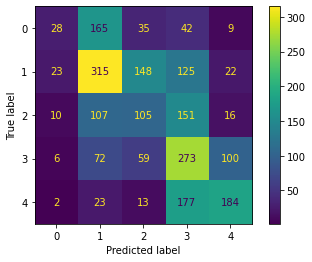

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
MulticlassCM = confusion_matrix( true_Y, predict_Y )
MultiClassDisp = ConfusionMatrixDisplay( MulticlassCM )
MultiClassDisp.plot()

### Use the regression version of the model
Did the regression model loss not change because it just converged very very quickly in all versions of it?

In [43]:
predict_Y_reg = model.predict( test_X )
predict_Y_reg = np.argmax(predict_Y_reg, axis=1)
print(max(predict_Y_reg))
predict_Y_reg

0


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)